In [1]:
sys.path.append('../Models')

import sys
import numpy as np
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from model_training import *
from CNN import ErnNet
from training_functions import *
from cross_validation import *

In [2]:
import yaml
def read_params(config_path):
    with open(config_path) as yaml_file:
        config = yaml.safe_load(yaml_file)
    return config

config = read_params('settings.yaml')

In [3]:
batch_size = config['batch_size']
num_epochs = config['number_epochs']
compressed_data_path = config['compressed_data_path']
lr = config['lr']
transition_steps = config['transition_steps']
gamma = config['gamma_value']

In [4]:
data = decompress_data(compressed_data_path)

# Get data loaders
data_loaders_and_classes = get_loaders_and_classes(data, batch_size)

In [5]:
device = get_device()

# Initialise model
model = ErnNet()

# Initialising training parameters
class_weights = get_class_weights(data['y_train'], device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr)

# Scheduling parameters
scheduler = Scheduler(optimizer, transition_steps, gamma)
lr_scheduler = scheduler.get_MultiStepLR()

Running on the GPU
/home/nyasha/anaconda3/envs/condaenv/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=['2_walking' 'clutter/noise' 'running' 'sphere_swing' 'vehicle' 'walking'], y=['2_walking' 'sphere_swing' 'vehicle' ... 'clutter/noise' 'running'
 'sphere_swing'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
Adjusting learning rate of group 0 to 1.0000e-04.


In [19]:
from torch.nn import parameter
import torch.nn.utils.prune as prune

from utility_functions import get_pytorch_model
from CNN import ErnNet

weights_path = 'checkpoint.pt'
model = ErnNet()

unpruned_model = get_pytorch_model(weights_path, model)

unpruned_model.first_layer

parameters_to_prune = (
    (unpruned_model.first_layer.conv1, 'weight'),
    (unpruned_model.block1.conv1, 'weight'),
    (unpruned_model.block1.conv2, 'weight'),
    (unpruned_model.block2.conv1, 'weight'),
    (unpruned_model.block2.conv2, 'weight'),
    (unpruned_model.block3.conv1, 'weight'),
    (unpruned_model.block3.conv2, 'weight'),
    (unpruned_model.fc1, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.05,
)

In [20]:
print(
    "Sparsity in conv1.weight: {:.2f}%".format(
        100. * float(torch.sum(unpruned_model.fc1.weight == 0))
        / float(unpruned_model.fc1.weight.nelement())
    )
)

Sparsity in conv1.weight: 0.00%


In [6]:
model_trainer = ModelTrainer(model, criterion, data_loaders_and_classes)

Running on the GPU


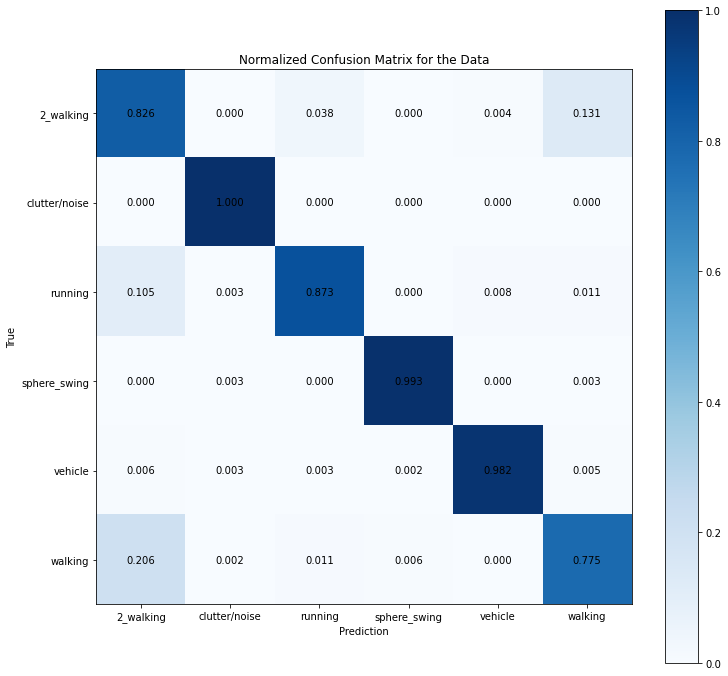

90.92599479360356


In [21]:
model_trainer.compressed_model = unpruned_model
unpruned_model.to('cuda')
_, accuracy, _, _, _ = model_trainer.evaluate_model(unpruned_model, data_loaders_and_classes['val_loader'], True)
print(accuracy)